In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

import numpy as np
import matplotlib.pyplot as plt

from kdelearn.cutils import gaussian, uniform, epanechnikov, cauchy
from kdelearn.kde import KDE
from kdelearn.ckde import CKDE
from kdelearn.kde_tasks import KDEClassification, KDEOutliersDetection, KDEClustering
from kdelearn.bandwidth_selection import normal_reference, direct_plugin
from kdelearn.metrics import pi_kf, density_silhouette
from kdelearn.ckde_tasks import CKDEClassification, CKDEOutliersDetection, CKDEClustering

import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"  # computer modern (latex default style)
matplotlib.rcParams["font.family"] = "STIXGeneral"

# Unconditional case

## KDE

$$
\hat{f}_X(x) = \sum_{i=1}^m w_i \mathcal{K} (x,x_i,h)
$$

$$
\mathcal{K}(x,x_i,h) = \prod_{j=1}^n \frac{1}{h_j} K_j \left( \frac{x_j-x_{i,j}}{h_j} \right)
$$

$$\hat{f}(x) = \sum_{i=1}^m w_{i} \prod_{j=1}^n \frac{1}{h_j} K \left( \frac{x_{j} - x_{i, j}}{h_j} \right) \text{,} \quad x \in \mathbb{R}^n$$

* $m$ - liczność zbioru
* $n$ - wymiarowość
* $\mathbf{w}$ - wagi wszystkich elementów zbioru
* $K(x)$ - funkcja jądrowa
* $\mathbf{h}$ - parametr wygładzania

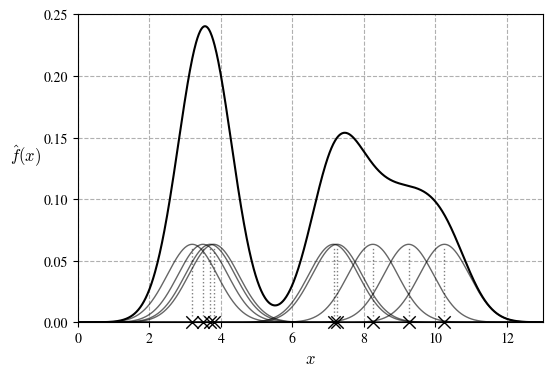

In [3]:
bandwidth = np.array([0.7])

x1, x2, x3, x4, x5, x6, x7, x8, x9 = 3.2, 3.5, 3.7, 3.8, 7.15, 7.25, 8.25, 9.25, 10.25
x_train = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9])[:, None]
m_train = x_train.shape[0]
x_grid = np.linspace(0, 13, 1000)[:, None]

plt.figure(figsize=(6, 4), dpi=100)

for x_i in x_train:
    scores = [1 / (m_train * bandwidth[0]) * gaussian((x - x_i) / bandwidth[0]) for x in x_grid]
    plt.plot(x_grid, scores, c="k", linewidth=1, alpha=0.6)
scores = KDE().fit(x_train, bandwidth=bandwidth).pdf(x_grid)
plt.plot(x_grid, scores, c="k")
plt.scatter(x_train, x_train*0, s=80, marker="x", c="k", clip_on=False, linewidth=1)
for i in range(m_train):
    plt.axvline(x_train[i], ymin=0.02, ymax=0.24, color="k", linewidth=1, linestyle=":", alpha=0.5)

# plt.title("Kernel density estimation", fontsize=11)
plt.xlim(0, 13)
plt.ylim(0, 0.25)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("../docs/images/kde_construction.png", dpi=200)
# plt.savefig("kde_construction.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Kernels

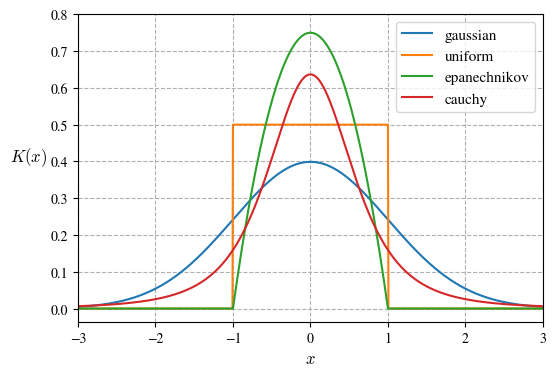

In [4]:
x_grid = np.linspace(-3, 3, 1000)

plt.figure(figsize=(6, 4), dpi=100)

for kernel in [gaussian, uniform, epanechnikov, cauchy]:
    scores = [kernel(x) for x in x_grid]
    plt.plot(x_grid, scores, label=kernel.__name__)

# # Zmiana legendy na potrzeby rozprawy
# for kernel, kname in [[gaussian, "normalne"], [uniform, "jednorodne"],
#                       [epanechnikov, "epanechnikowa"], [cauchy, "cauchy'ego"]]:
#     scores = [kernel(x) for x in x_grid]
#     plt.plot(x_grid, scores, label=kname)

# plt.title("Available kernel functions")
plt.legend(fontsize=11)
plt.xlim(-3, 3)
plt.ylim(top=0.8)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$K(x)$", rotation=0, labelpad=16, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("../docs/images/kernels.png", dpi=200)
# plt.savefig("kernels.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Bandwidth selection

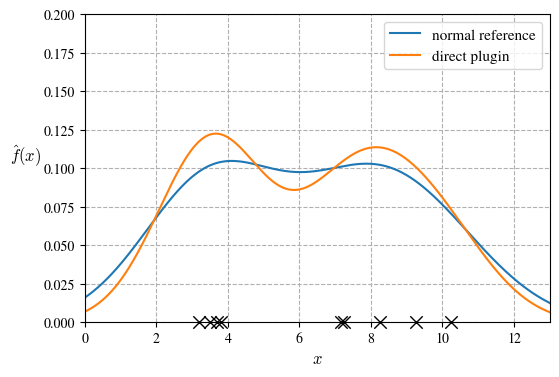

In [5]:
bandwidth = np.array([0.7])

x1, x2, x3, x4, x5, x6, x7, x8, x9 = 3.2, 3.5, 3.7, 3.8, 7.15, 7.25, 8.25, 9.25, 10.25
x_train = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9])[:, None]
m_train = x_train.shape[0]
x_grid = np.linspace(0, 13, 1000)[:, None]

plt.figure(figsize=(6, 4), dpi=100)

bandwidth1 = normal_reference(x_train)
scores1 = KDE().fit(x_train, bandwidth=bandwidth1).pdf(x_grid)
plt.plot(x_grid, scores1, label="normal reference")
bandwidth2 = direct_plugin(x_train)
scores2 = KDE().fit(x_train, bandwidth=bandwidth2).pdf(x_grid)
plt.plot(x_grid, scores2, label="direct plugin")
plt.scatter(x_train, x_train*0, s=80, marker="x", c="k", clip_on=False, linewidth=1)

# plt.title("Kernel density estimation", fontsize=11)
plt.legend(fontsize=11)
plt.xlim(0, 13)
plt.ylim(0, 0.2)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("../docs/images/kde_construction.png", dpi=200)
# plt.savefig("bandwidth_selection.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Syntetic data

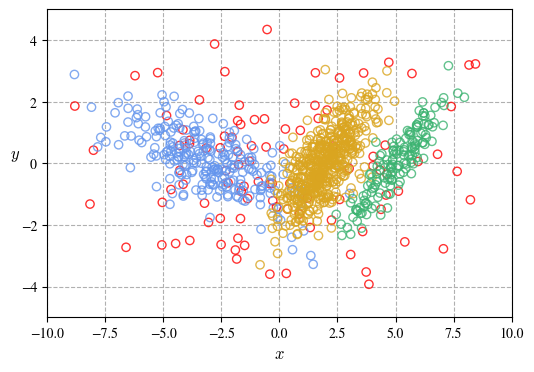

In [6]:
np.random.seed(1)
# Data
m_train = 1000
n_x, n_y = 1, 1

## class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
x_train1 = z_train1[:, [0]]
y_train1 = z_train1[:, [1]]
labels_train1 = np.full(m_train1, 1, dtype=np.int32)

## class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
x_train2 = z_train2[:, [0]]
y_train2 = z_train2[:, [1]]
labels_train2 = np.full(m_train2, 2, dtype=np.int32)

## class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
x_train3 = z_train3[:, [0]]
y_train3 = z_train3[:, [1]]
labels_train3 = np.full(m_train3, 3, dtype=np.int32)

## class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]
z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)
x_train4 = z_train4[:, [0]]
y_train4 = z_train4[:, [1]]
labels_train4 = np.full(m_train4, 4, dtype=np.int32)

## 
x_train = np.concatenate((x_train1, x_train2, x_train3, x_train4), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train4, y_train4, facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")
plt.show()

### Outliers detection

In [7]:
x_grid = np.linspace(-10, 10, 1000)[:, None]

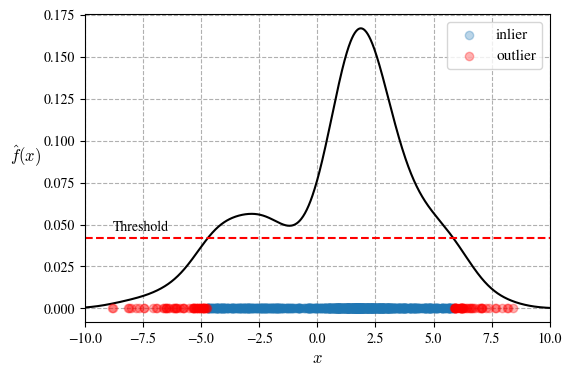

In [8]:
kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth_method="normal_reference")
scores = kde_outlier_detector.kde.pdf(x_grid)
labels_pred = kde_outlier_detector.predict(x_train)

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, scores, c="k")
plt.hlines(kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, zorder=2, alpha=0.3, label="inlier")
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, zorder=2, alpha=0.3, c="red", label="outlier")
plt.text(-8.8, 0.046, "Threshold")

plt.legend(fontsize=11)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

# plt.savefig("kde_outliers_detection.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Wskaźnik jakości

In [79]:
metrics = pi_kf(x_train, x_train, labels_pred)
print(f"Wskaźnik jakości (PI_kf): {metrics:.6f}")

Wskaźnik jakości (PI_kf): 0.548549


$$
PI = \frac{ \frac{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{out})}{m_{out}} }{ \frac{\sum_{i=1}^{m_{in}} \hat{f}(x_i^{in})}{m_{in}} }
$$

#### Siatka

Najlepszy wskaźnik jakości (PI_kf): 0.517670
Dla mnożnika: 0.5


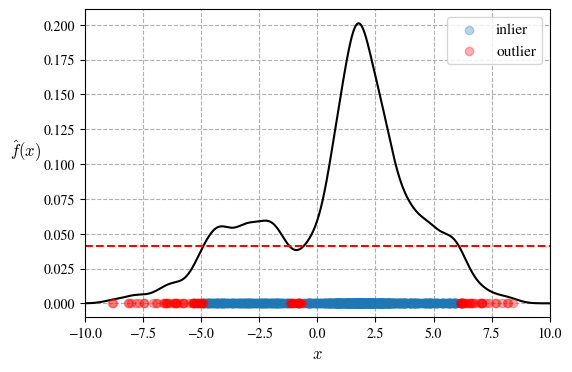

In [80]:
tt = [1.0, 0.95, 1.05, 0.9, 1.1, 0.75, 1.5, 0.5, 2.0]

metrics_list = []
for x_factor in tt:
    tmp_bandwidth = normal_reference(x_train) * x_factor
    tmp_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=tmp_bandwidth)
    tmp_labels_pred = tmp_outlier_detector.predict(x_train)

    metrics = pi_kf(x_train, x_train, tmp_labels_pred)
    metrics_list.append(metrics)

argmin = np.argmin(metrics_list)
best_bandwidth_multiplier = tt[argmin]

print(f"Najlepszy wskaźnik jakości (PI_kf): {metrics_list[argmin]:.6f}")
print(f"Dla mnożnika: {best_bandwidth_multiplier}")


####
best_bandwidth = normal_reference(x_train) * best_bandwidth_multiplier
best_kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=best_bandwidth)
scores = best_kde_outlier_detector.kde.pdf(x_grid)
labels_pred = best_kde_outlier_detector.predict(x_train)


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, scores, c="k")
plt.hlines(best_kde_outlier_detector.threshold, -10, 10, linestyle="--", color="r")
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, zorder=2, alpha=0.3, label="inlier")
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, zorder=2, alpha=0.3, c="red", label="outlier")

plt.legend(fontsize=11)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

# plt.savefig("opt_kde_outliers_detection.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Clustering

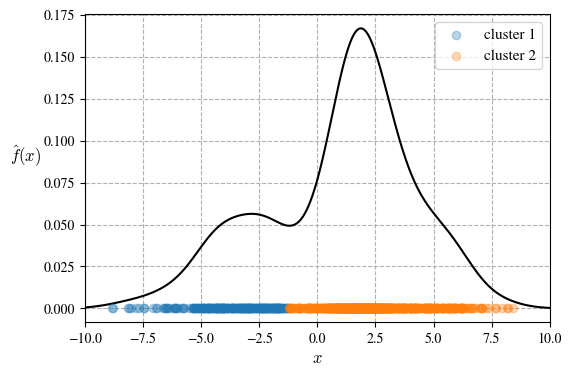

In [11]:
kde = KDE().fit(x_train, bandwidth_method="normal_reference")
scores = kde.pdf(x_grid)

kde_clustering = KDEClustering().fit(x_train, bandwidth_method="normal_reference")
labels_pred = kde_clustering.predict(x_train)

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, scores, c="k")
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, zorder=2, alpha=0.3, label="cluster 1")
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, zorder=2, alpha=0.3, label="cluster 2")

plt.legend(fontsize=11)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

# plt.savefig("kde_clustering.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Wskaźnik jakości

In [12]:
dbs_scores, dbs_mean = density_silhouette(x_train, labels_pred)
print(f"Wskaźnik jakości (dbs): {dbs_mean:.6f}")

Wskaźnik jakości (dbs): 0.186292


#### Siatka

Najlepszy wskaźnik jakości (dbs): 0.201591
Dla mnożnika: 0.5


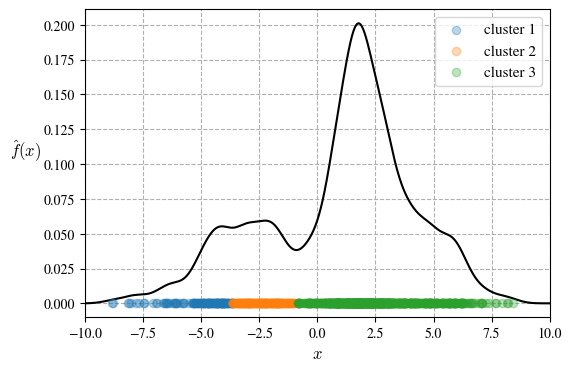

In [13]:
tt = [1.0, 0.95, 1.05, 0.9, 1.1, 0.75, 0.5]

metrics_list = []
for x_factor in tt:
    tmp_bandwidth = normal_reference(x_train) * x_factor
    tmp_kde_clustering = KDEClustering().fit(x_train, bandwidth=tmp_bandwidth)
    tmp_labels_pred = tmp_kde_clustering.predict(x_train)

    dbs_scores, dbs_mean = density_silhouette(x_train, tmp_labels_pred)
    metrics_list.append(dbs_mean)

argmax = np.argmax(metrics_list)
best_bandwidth_multiplier = tt[argmax]

print(f"Najlepszy wskaźnik jakości (dbs): {metrics_list[argmax]:.6f}")
print(f"Dla mnożnika: {best_bandwidth_multiplier}")


####
best_bandwidth = normal_reference(x_train) * best_bandwidth_multiplier
kde = KDE().fit(x_train, bandwidth=best_bandwidth)
scores = kde.pdf(x_grid)

best_kde_clustering = KDEClustering().fit(x_train, bandwidth=best_bandwidth)
labels_pred = best_kde_clustering.predict(x_train)


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, scores, c="k")
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, zorder=2, alpha=0.3, label="cluster 1")
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, zorder=2, alpha=0.3, label="cluster 2")
plt.scatter(x_train[labels_pred==2, 0], x_train[labels_pred==2, 0]*0, zorder=2, alpha=0.3, label="cluster 3")

plt.legend(fontsize=11)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

# plt.savefig("opt_kde_clustering.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Classification

In [108]:
x_train = np.concatenate((x_train1, x_train2, x_train3), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3))
m_train = x_train.shape[0]

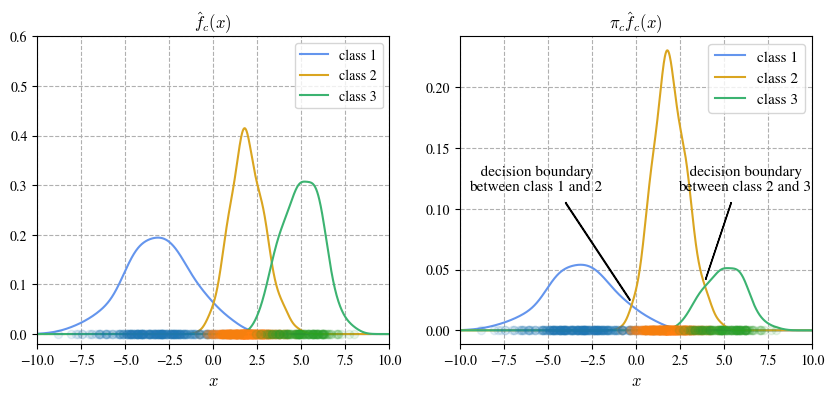

In [208]:
kde_classifier = KDEClassification().fit(x_train, labels_train, bandwidth_method="normal_reference")


kde1 = KDE().fit(x_train1, bandwidth_method="normal_reference")
scores1 = kde1.pdf(x_grid)
kde2 = KDE().fit(x_train2, bandwidth_method="normal_reference")
scores2 = kde2.pdf(x_grid)
kde3 = KDE().fit(x_train3, bandwidth_method="normal_reference")
scores3 = kde3.pdf(x_grid)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores1, c="cornflowerblue", label="class 1")
axs[0].plot(x_grid, scores2, c="goldenrod", label="class 2")
axs[0].plot(x_grid, scores3, c="mediumseagreen", label="class 3")
axs[0].scatter(x_train1[:, 0], x_train1[:, 0]*0, zorder=2, alpha=0.1)
axs[0].scatter(x_train2[:, 0], x_train2[:, 0]*0, zorder=2, alpha=0.1)
axs[0].scatter(x_train3[:, 0], x_train3[:, 0]*0, zorder=2, alpha=0.1)
axs[0].set_title("$\hat{f}_c(x)$", fontsize=12)
axs[0].legend(fontsize=10)
axs[0].set_xlabel("$x$", fontsize=12)
# axs[0].set_ylabel("$f$", rotation=0)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.6)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores1, c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores3, c="mediumseagreen", label="class 3")
axs[1].scatter(x_train1[:, 0], x_train1[:, 0]*0, zorder=2, alpha=0.1)
axs[1].scatter(x_train2[:, 0], x_train2[:, 0]*0, zorder=2, alpha=0.1)
axs[1].scatter(x_train3[:, 0], x_train3[:, 0]*0, zorder=2, alpha=0.1)
axs[1].arrow(-4, 0.105, 3.65, -0.08, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=2, linestyle="-")
axs[1].text(-9.5, 0.115, "   decision boundary\nbetween class 1 and 2", fontsize=11)
axs[1].arrow(5.4, 0.105, -1.45, -0.063, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=2, linestyle="-")
axs[1].text(2.4, 0.115, "   decision boundary\nbetween class 2 and 3", fontsize=11)
axs[1].set_title("$\\pi_c \\hat{f}_c(x)$", fontsize=12)
axs[1].legend(fontsize=11)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel("$x$", fontsize=12)
# axs[1].set_ylabel("$f$", rotation=0)
axs[1].grid(linestyle="--")

# plt.savefig("kde_classification.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Wskaźnik jakości

Leave-one-out accuracy

In [209]:
labels_pred = np.empty((m_train,), dtype=np.int32)
for i in range(m_train):
    mask = np.delete(np.arange(m_train), i)
    classifier = KDEClassification().fit(
        x_train[mask],
        labels_train[mask],
    )
    labels_pred[i] = classifier.predict(x_train[[i]])

accuracy = np.mean(labels_train == labels_pred)
print(f"Wskaźnik jakości (loo accuracy): {accuracy:.6f}")

Wskaźnik jakości (loo accuracy): 0.925556


#### Siatka

Najlepszy wskaźnik jakości (dokładność): 0.926667
Dla mnożników: (2.0, 1.0, 1.0)


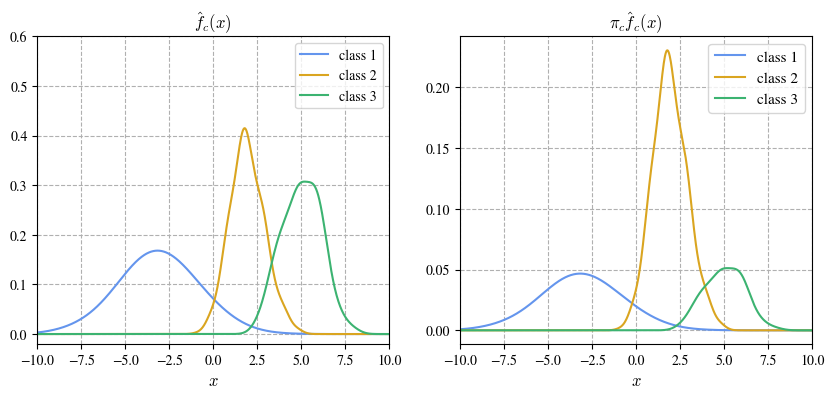

In [211]:
# x = [1.0, 0.75, 1.5, 0.5, 2.0]
x = [1.0, 0.5, 2.0]
tt = [p for p in itertools.product(x, repeat=3)]

ulabels = np.unique(labels_train)  # Sorted unique labels
n_classes = ulabels.shape[0]

metrics_list = []
for x_fac_c1, x_fac_c2, x_fac_c3 in tt:
    bandwidths = np.zeros((n_classes, 1))
    for idx, label in enumerate(ulabels):
        mask = labels_train == label
        bandwidths[idx, :] = normal_reference(x_train[mask])
    bandwidths = (bandwidths[:, 0] * np.array([x_fac_c1, x_fac_c2, x_fac_c3]))[:, None]
    
    # LOO accuracy
    labels_pred = np.empty((m_train,), dtype=np.int32)
    for i in range(m_train):
        mask = np.delete(np.arange(m_train), i)
        classifier = KDEClassification().fit(
            x_train[mask],
            labels_train[mask],
            bandwidths=bandwidths
        )
        labels_pred[i] = classifier.predict(x_train[[i]])
    
    metrics = np.mean(labels_pred == labels_train)
    metrics_list.append(metrics)

argmax = np.argmax(metrics_list)
best_bandwidth_multipliers = tt[argmax]

print(f"Najlepszy wskaźnik jakości (dokładność): {metrics_list[argmax]:.6f}")
print(f"Dla mnożników: {best_bandwidth_multipliers}")


####
best_bandwidths = np.zeros((3, 1))
for idx, label in enumerate(ulabels):
    mask = labels_train == label
    best_bandwidths[idx, :] = normal_reference(x_train[mask])
best_bandwidths = (best_bandwidths[:, 0] * np.array(best_bandwidth_multipliers))[:, None]
# kde_classifier = KDEClassification().fit(x_train, labels_train, bandwidths=best_bandwidths)


kde1 = KDE().fit(x_train1, bandwidth=best_bandwidths[0, :])
scores1 = kde1.pdf(x_grid)
kde2 = KDE().fit(x_train2, bandwidth=best_bandwidths[1, :])
scores2 = kde2.pdf(x_grid)
kde3 = KDE().fit(x_train3, bandwidth=best_bandwidths[2, :])
scores3 = kde3.pdf(x_grid)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores1, c="cornflowerblue", label="class 1")
axs[0].plot(x_grid, scores2, c="goldenrod", label="class 2")
axs[0].plot(x_grid, scores3, c="mediumseagreen", label="class 3")
axs[0].set_title("$\hat{f}_c(x)$", fontsize=12)
axs[0].legend(fontsize=10)
axs[0].set_xlabel("$x$", fontsize=12)
# axs[0].set_ylabel("$f$", rotation=0)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.6)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores1, c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores3, c="mediumseagreen", label="class 3")
axs[1].set_title("$\\pi_c \\hat{f}_c(x)$", fontsize=12)
axs[1].legend(fontsize=11)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel("$x$", fontsize=12)
# axs[1].set_ylabel("$f$", rotation=0)
axs[1].grid(linestyle="--")

# plt.savefig("opt_kde_classification.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Conditional case

$$
\hat{f}_{X \mid Y}(x \mid y^*) = \frac{\hat{f}_{X,Y}(x,y^*)}{\hat{f}_Y(y)}
$$

## Syntetic data

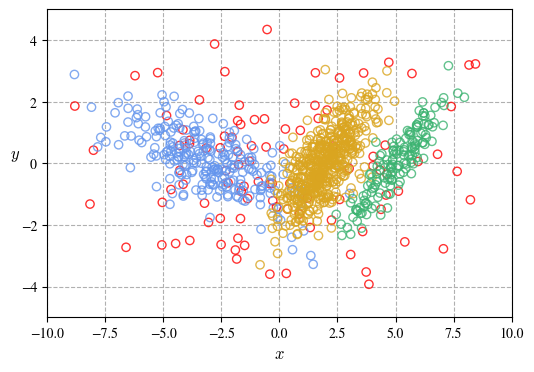

In [23]:
np.random.seed(1)
# Data
m_train = 1000
n_x, n_y = 1, 1

## class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
x_train1 = z_train1[:, [0]]
y_train1 = z_train1[:, [1]]
labels_train1 = np.full(m_train1, 1, dtype=np.int32)

## class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
x_train2 = z_train2[:, [0]]
y_train2 = z_train2[:, [1]]
labels_train2 = np.full(m_train2, 2, dtype=np.int32)

## class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
x_train3 = z_train3[:, [0]]
y_train3 = z_train3[:, [1]]
labels_train3 = np.full(m_train3, 3, dtype=np.int32)

## class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]
z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)
x_train4 = z_train4[:, [0]]
y_train4 = z_train4[:, [1]]
labels_train4 = np.full(m_train4, 4, dtype=np.int32)

## 
x_train = np.concatenate((x_train1, x_train2, x_train3, x_train4), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train4, y_train4, facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")
plt.show()

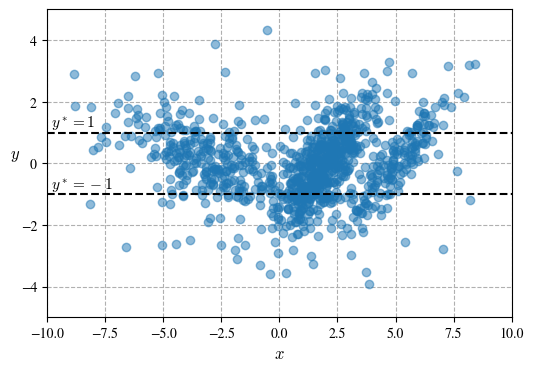

In [24]:
# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train, y_train, zorder=2, alpha=0.5)
plt.hlines(1, -10, 10, color="k", linestyle="--")
plt.text(-9.8, 1.2, "$y^*=1$", fontsize=11)
plt.hlines(-1, -10, 10, color="k", linestyle="--")
plt.text(-9.8, -0.8, "$y^*=-1$", fontsize=11)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("ckde_data0.pdf", format="pdf", bbox_inches="tight")
plt.show()

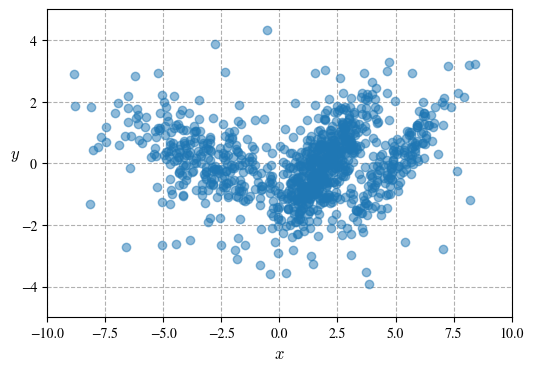

In [25]:
# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train, y_train, zorder=2, alpha=0.5)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("ckde_data1.pdf", format="pdf", bbox_inches="tight")
plt.show()

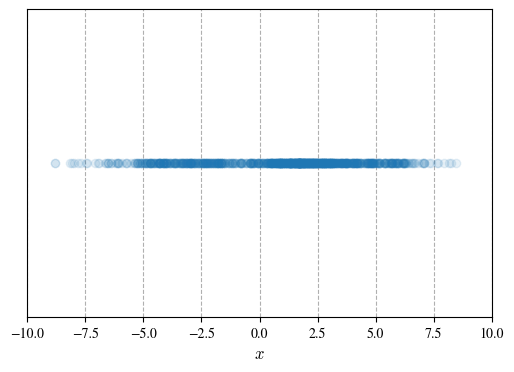

In [26]:
# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train, x_train*0, zorder=2, alpha=0.1)

plt.yticks([])

plt.xlim(-10, 10)
# plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("kde_data1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [27]:
y_star = np.array([1.0])

### CKDE

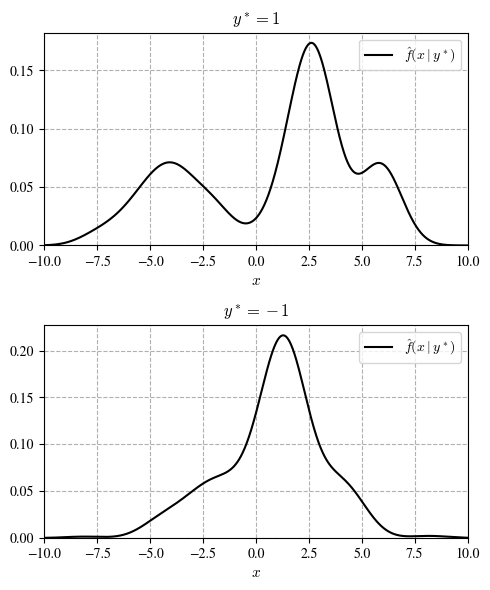

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(5, 6), dpi=100)

ckde = CKDE().fit(x_train, y_train, np.array([1.0]), bandwidth_method="normal_reference")
scores = ckde.pdf(x_grid)
axs[0].plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")

axs[0].set_title("$y^*=1$")
axs[0].legend()
axs[0].set_xlabel("$x$", fontsize=11)
# axs[0].set_ylabel("$f$", rotation=0, fontsize=11)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(bottom=0)
axs[0].grid(linestyle="--")


ckde = CKDE().fit(x_train, y_train, np.array([-1.0]), bandwidth_method="normal_reference")
scores = ckde.pdf(x_grid)
axs[1].plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")

axs[1].set_title("$y^*=-1$")
axs[1].legend()
axs[1].set_xlabel("$x$", fontsize=11)
# axs[1].set_ylabel("$f$", rotation=0, fontsize=11)
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(bottom=0)
axs[1].grid(linestyle="--")

plt.tight_layout()
# plt.savefig("ckde_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

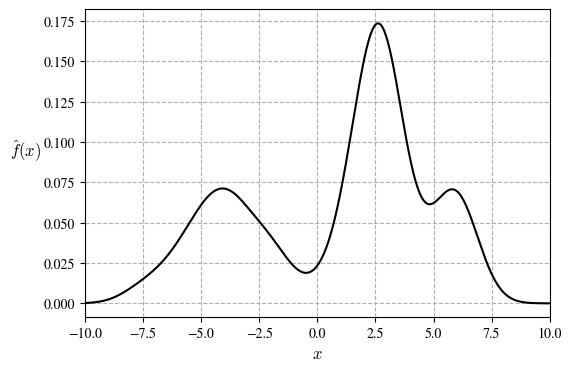

In [14]:
ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_method="normal_reference")
scores = ckde.pdf(x_grid)

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, scores, c="k")
# plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0]*0, zorder=2, alpha=0.3, label="inlier")
# plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0]*0, zorder=2, alpha=0.3, c="red", label="outlier")

# plt.legend(fontsize=11)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

# plt.savefig("ckde_pos.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Clustering

In [219]:
ckde_clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_method="normal_reference")
labels_pred = ckde_clustering.predict(x_train)

In [46]:
cond = (y_star[0] - 0.5*np.std(y_train[:, 0]) < y_train[:, 0]) & (y_train[:, 0] < y_star[0] + 0.5*np.std(y_train[:, 0]))

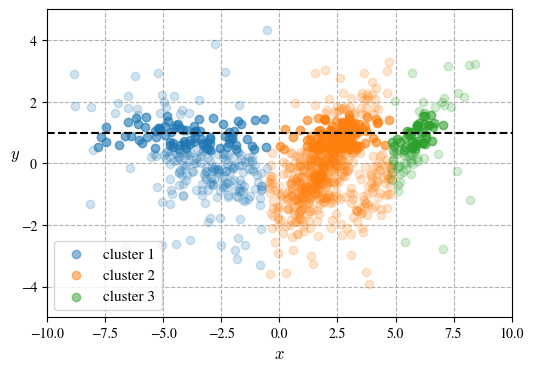

In [59]:
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[labels_pred == 0], y_train[labels_pred == 0], zorder=2, alpha=0.2)
plt.scatter(x_train[((labels_pred == 0) & (cond))], y_train[((labels_pred == 0) & (cond))], zorder=2, alpha=0.5, c="#1f77b4", label="cluster 1")

plt.scatter(x_train[labels_pred == 1], y_train[labels_pred == 1], zorder=2, alpha=0.2)
plt.scatter(x_train[((labels_pred == 1) & (cond))], y_train[((labels_pred == 1) & (cond))], zorder=2, alpha=0.5, c="#ff7f0e", label="cluster 2")

plt.scatter(x_train[labels_pred == 2], y_train[labels_pred == 2], zorder=2, alpha=0.2)
plt.scatter(x_train[((labels_pred == 2) & (cond))], y_train[((labels_pred == 2) & (cond))], zorder=2, alpha=0.5, c="#2ca02c", label="cluster 3")

plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend(fontsize=11)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")

# plt.savefig("ckde_clustering.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Outliers detection

In [88]:
ckde_outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star)
labels_pred = ckde_outlier_detector.predict(x_train)

In [90]:
cond = (y_star[0] - 0.5*np.std(y_train[:, 0]) < y_train[:, 0]) & (y_train[:, 0] < y_star[0] + 0.5*np.std(y_train[:, 0]))

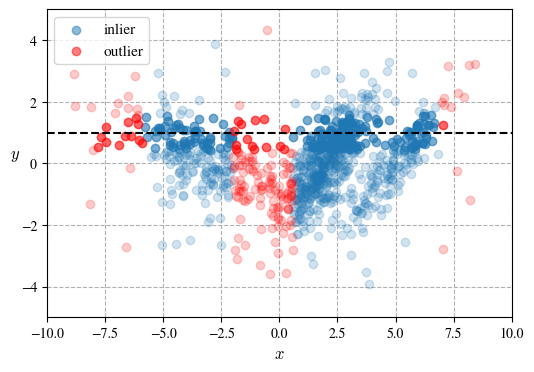

In [100]:
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[labels_pred == 0], y_train[labels_pred == 0], zorder=2, alpha=0.2, c="#1f77b4")
plt.scatter(x_train[((labels_pred == 0) & (cond))], y_train[((labels_pred == 0) & (cond))], zorder=2, alpha=0.5, label="inlier", c="#1f77b4")

plt.scatter(x_train[labels_pred == 1], y_train[labels_pred == 1], zorder=2, alpha=0.2, c="red")
plt.scatter(x_train[((labels_pred == 1) & (cond))], y_train[((labels_pred == 1) & (cond))], zorder=2, alpha=0.5, label="outlier", c="red")

plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend(fontsize=11)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("ckde_outliers_detection.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Classification

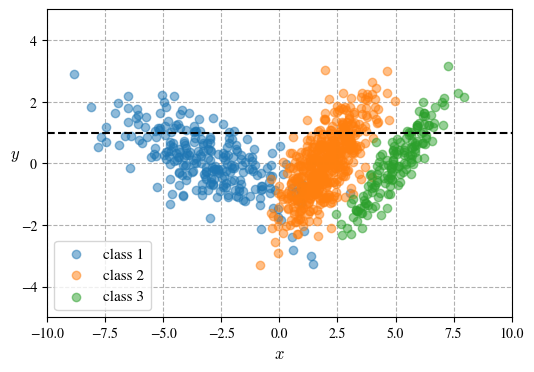

In [28]:
# Train data
x_train = np.concatenate((x_train1, x_train2, x_train3), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3))
m_train = x_train.shape[0]

plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train1, y_train1, zorder=2, alpha=0.5, label="class 1")
plt.scatter(x_train2, y_train2, zorder=2, alpha=0.5, label="class 2")
plt.scatter(x_train3, y_train3, zorder=2, alpha=0.5, label="class 3")
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend(fontsize=11)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", rotation=0, fontsize=12)
plt.grid(linestyle="--")

# plt.savefig("ckde_classification_data.pdf", format="pdf", bbox_inches="tight")
plt.show()

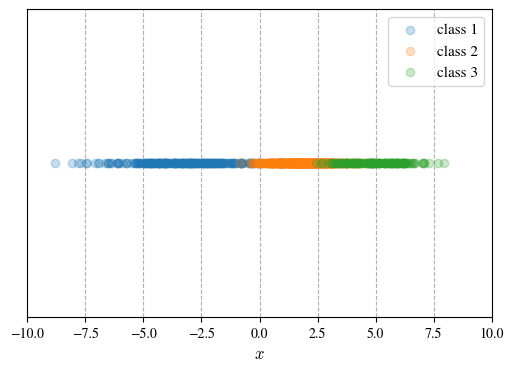

In [16]:
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train1, x_train1*0, zorder=2, alpha=0.25, label="class 1")
plt.scatter(x_train2, x_train2*0, zorder=2, alpha=0.25, label="class 2")
plt.scatter(x_train3, x_train3*0, zorder=2, alpha=0.25, label="class 3")

plt.yticks([])

plt.legend(fontsize=11)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$", fontsize=12)
plt.grid(linestyle="--")

# plt.savefig("kde_classification_data.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### $y^* = y_i$

In [17]:
labels_pred = np.empty((m_train,), dtype=np.int32)
for i in range(m_train):
    mask = np.delete(np.arange(m_train), i)
    tmp_classifier = CKDEClassification().fit(
        x_train[mask],
        y_train[mask],
        y_train[i],
        labels_train[mask],
        bandwidth_method="normal_reference"
    )
    labels_pred[i] = tmp_classifier.predict(x_train[[i]])

accuracy = np.mean(labels_train == labels_pred)
print(f"Wskaźnik jakości (loo accuracy): {accuracy:.6f}")

Wskaźnik jakości (loo accuracy): 0.972222


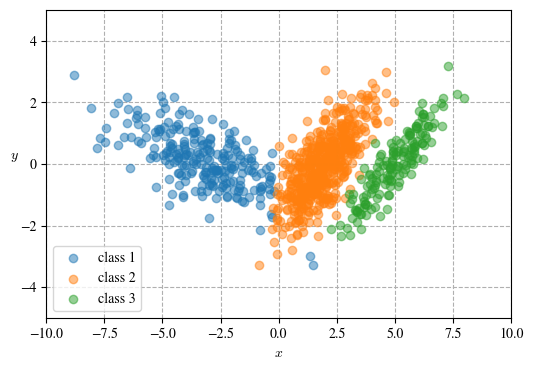

In [22]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], zorder=2, alpha=0.5, label="class 1")
plt.scatter(x_train[labels_pred==2], y_train[labels_pred==2], zorder=2, alpha=0.5, label="class 2")
plt.scatter(x_train[labels_pred==3], y_train[labels_pred==3], zorder=2, alpha=0.5, label="class 3")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
# plt.savefig("ckde_classification3.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Testowanie przy $y^*=1$

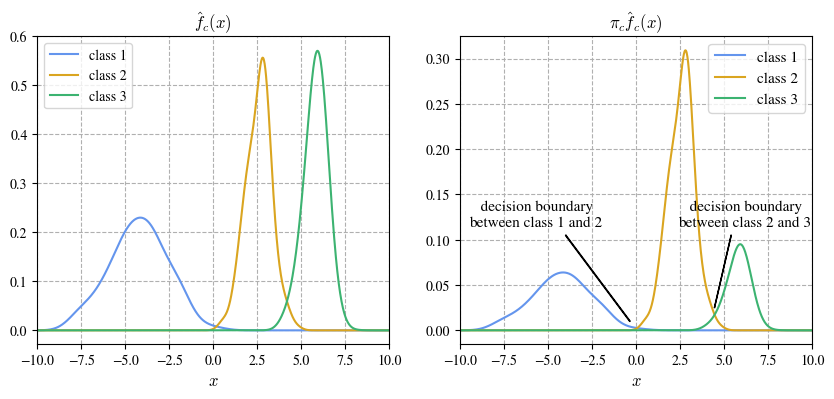

In [54]:

ckde1 = CKDE().fit(x_train1, y_train1, y_star, bandwidth_method="normal_reference")
scores1 = ckde1.pdf(x_grid)
ckde2 = CKDE().fit(x_train2, y_train2, y_star, bandwidth_method="normal_reference")
scores2 = ckde2.pdf(x_grid)
ckde3 = CKDE().fit(x_train3, y_train3, y_star, bandwidth_method="normal_reference")
scores3 = ckde3.pdf(x_grid)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].plot(x_grid, scores1, c="cornflowerblue", label="class 1")
axs[0].plot(x_grid, scores2, c="goldenrod", label="class 2")
axs[0].plot(x_grid, scores3, c="mediumseagreen", label="class 3")
# axs[0].scatter(x_train1[:, 0], x_train1[:, 0]*0, zorder=2, alpha=0.1)
# axs[0].scatter(x_train2[:, 0], x_train2[:, 0]*0, zorder=2, alpha=0.1)
# axs[0].scatter(x_train3[:, 0], x_train3[:, 0]*0, zorder=2, alpha=0.1)
axs[0].set_title("$\hat{f}_c(x)$", fontsize=12)
axs[0].legend(fontsize=10)
axs[0].set_xlabel("$x$", fontsize=12)
# axs[0].set_ylabel("$f$", rotation=0)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=0.6)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores1, c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores3, c="mediumseagreen", label="class 3")
# axs[1].scatter(x_train1[:, 0], x_train1[:, 0]*0, zorder=2, alpha=0.1)
# axs[1].scatter(x_train2[:, 0], x_train2[:, 0]*0, zorder=2, alpha=0.1)
# axs[1].scatter(x_train3[:, 0], x_train3[:, 0]*0, zorder=2, alpha=0.1)
axs[1].arrow(-4, 0.105, 3.65, -0.095, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=2, linestyle="-")
axs[1].text(-9.5, 0.115, "   decision boundary\nbetween class 1 and 2", fontsize=11)
axs[1].arrow(5.4, 0.105, -0.95, -0.08, head_width=0.0, head_length=0.0, fc='k', ec='k', zorder=2, linestyle="-")
axs[1].text(2.4, 0.115, "   decision boundary\nbetween class 2 and 3", fontsize=11)
axs[1].set_title("$\\pi_c \\hat{f}_c(x)$", fontsize=12)
axs[1].legend(fontsize=11)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel("$x$", fontsize=12)
# axs[1].set_ylabel("$f$", rotation=0)
axs[1].grid(linestyle="--")

# plt.savefig("ckde_classification2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [21]:
# Classify
ckde_classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train, bandwidth_method="normal_reference")
labels_pred = ckde_classifier.predict(x_train)

print(f"Wskaźnik jakości (dokładność): {np.mean(labels_pred == labels_train):.6f}")

Wskaźnik jakości (dokładność): 0.914444


In [25]:
cond = (y_star[0] - 0.5*np.std(y_train[:, 0]) < y_train[:, 0]) & (y_train[:, 0] < y_star[0] + 0.5*np.std(y_train[:, 0]))

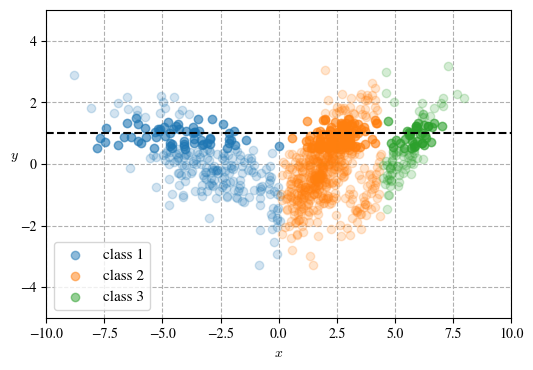

In [36]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], zorder=2, alpha=0.2, c="#1f77b4")
plt.scatter(x_train[((labels_pred == 1) & (cond))], y_train[((labels_pred == 1) & (cond))], zorder=2, alpha=0.5, c="#1f77b4", label="class 1")
plt.scatter(x_train[labels_pred==2], y_train[labels_pred==2], zorder=2, alpha=0.2, c="#ff7f0e")
plt.scatter(x_train[((labels_pred == 2) & (cond))], y_train[((labels_pred == 2) & (cond))], zorder=2, alpha=0.5, c="#ff7f0e", label="class 2")
plt.scatter(x_train[labels_pred==3], y_train[labels_pred==3], zorder=2, alpha=0.2, c="#2ca02c")
plt.scatter(x_train[((labels_pred == 3) & (cond))], y_train[((labels_pred == 3) & (cond))], zorder=2, alpha=0.5, c="#2ca02c", label="class 3")
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend(fontsize=11)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
# plt.savefig("ckde_classification.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Testowanie na zbiorze testowym (w otoczeniu $y^*$)

- Zbiór testowy wylosowany z tych samych rozkładów dwuwymiarowych, ale ograniczony w paśmie $y^* - 0.1y_{std} < y_i < y^* + 0.1y_{std} $

In [29]:
# Dane testowe w otoczeniu y_star=-1
np.random.seed(0)

y_star_neg = np.array([-1.0])
y_train_std = 0.1 * np.std(y_train)

## 1
m_test1_neg = 250
x_test1_neg = np.empty((m_test1_neg, n_x))
y_test1_neg = np.empty((m_test1_neg, n_y))
labels_test1_neg = np.full(m_test1_neg, 1, dtype=np.int64)
l = 0
while l < m_test1_neg:
    z_test1_neg = np.random.multivariate_normal(mean1, cov1, 1)
    if y_star_neg[0] - y_train_std < z_test1_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test1_neg[l] = z_test1_neg[:, [0]]
        y_test1_neg[l] = z_test1_neg[:, [1]]
        l += 1

## 2
m_test2_neg = 500
x_test2_neg = np.empty((m_test2_neg, n_x))
y_test2_neg = np.empty((m_test2_neg, n_y))
labels_test2_neg = np.full(m_test2_neg, 2, dtype=np.int64)
l = 0
while l < m_test2_neg:
    z_test2_neg = np.random.multivariate_normal(mean2, cov2, 1)
    if y_star_neg[0] - y_train_std < z_test2_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test2_neg[l] = z_test2_neg[:, [0]]
        y_test2_neg[l] = z_test2_neg[:, [1]]
        l += 1

## 3
m_test3_neg = 150
x_test3_neg = np.empty((m_test3_neg, n_x))
y_test3_neg = np.empty((m_test3_neg, n_y))
labels_test3_neg = np.full(m_test3_neg, 3, dtype=np.int64)
l = 0
while l < m_test3_neg:
    z_test3_neg = np.random.multivariate_normal(mean3, cov3, 1)
    if y_star_neg[0] - y_train_std < z_test3_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test3_neg[l] = z_test3_neg[:, [0]]
        y_test3_neg[l] = z_test3_neg[:, [1]]
        l += 1

## 
x_test_neg = np.concatenate((x_test1_neg, x_test2_neg, x_test3_neg), axis=0)
y_test_neg = np.concatenate((y_test1_neg, y_test2_neg, y_test3_neg), axis=0)
labels_test_neg = np.concatenate((labels_test1_neg, labels_test2_neg, labels_test3_neg))

In [30]:
# Classify
ckde_classifier = CKDEClassification().fit(x_train, y_train, y_star_neg, labels_train, bandwidth_method="direct_plugin")
labels_pred = ckde_classifier.predict(x_test_neg)

print(f"Wskaźnik jakości (dokładność): {np.mean(labels_pred == labels_test_neg):.6f}")

Wskaźnik jakości (dokładność): 0.928889


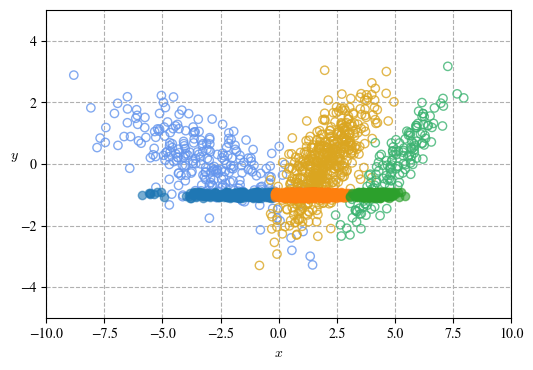

In [31]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

for c in np.unique(labels_pred):
    plt.scatter(x_test_neg[labels_pred==c], y_test_neg[labels_pred==c], zorder=2, alpha=0.6)

plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

In [32]:
# Dane testowe w otoczeniu y_star=0
np.random.seed(0)

y_star_neg = np.array([0.0])
y_train_std = 0.1 * np.std(y_train)

## 1
m_test1_neg = 250
x_test1_neg = np.empty((m_test1_neg, n_x))
y_test1_neg = np.empty((m_test1_neg, n_y))
labels_test1_neg = np.full(m_test1_neg, 1, dtype=np.int64)
l = 0
while l < m_test1_neg:
    z_test1_neg = np.random.multivariate_normal(mean1, cov1, 1)
    if y_star_neg[0] - y_train_std < z_test1_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test1_neg[l] = z_test1_neg[:, [0]]
        y_test1_neg[l] = z_test1_neg[:, [1]]
        l += 1

## 2
m_test2_neg = 500
x_test2_neg = np.empty((m_test2_neg, n_x))
y_test2_neg = np.empty((m_test2_neg, n_y))
labels_test2_neg = np.full(m_test2_neg, 2, dtype=np.int64)
l = 0
while l < m_test2_neg:
    z_test2_neg = np.random.multivariate_normal(mean2, cov2, 1)
    if y_star_neg[0] - y_train_std < z_test2_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test2_neg[l] = z_test2_neg[:, [0]]
        y_test2_neg[l] = z_test2_neg[:, [1]]
        l += 1

## 3
m_test3_neg = 150
x_test3_neg = np.empty((m_test3_neg, n_x))
y_test3_neg = np.empty((m_test3_neg, n_y))
labels_test3_neg = np.full(m_test3_neg, 3, dtype=np.int64)
l = 0
while l < m_test3_neg:
    z_test3_neg = np.random.multivariate_normal(mean3, cov3, 1)
    if y_star_neg[0] - y_train_std < z_test3_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test3_neg[l] = z_test3_neg[:, [0]]
        y_test3_neg[l] = z_test3_neg[:, [1]]
        l += 1

## 
x_test_neg = np.concatenate((x_test1_neg, x_test2_neg, x_test3_neg), axis=0)
y_test_neg = np.concatenate((y_test1_neg, y_test2_neg, y_test3_neg), axis=0)
labels_test_neg = np.concatenate((labels_test1_neg, labels_test2_neg, labels_test3_neg))

In [33]:
# Classify
ckde_classifier = CKDEClassification().fit(x_train, y_train, y_star_neg, labels_train, bandwidth_method="direct_plugin")
labels_pred = ckde_classifier.predict(x_test_neg)

print(f"Wskaźnik jakości (dokładność): {np.mean(labels_pred == labels_test_neg):.6f}")

Wskaźnik jakości (dokładność): 0.982222


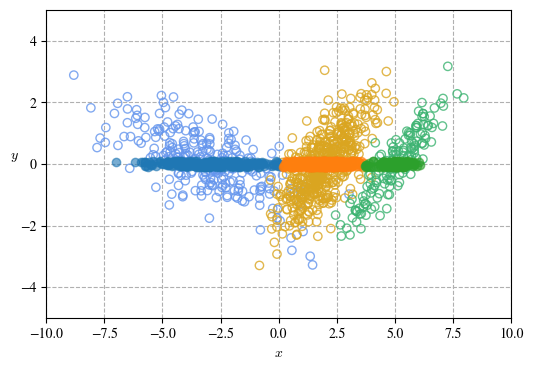

In [34]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

for c in np.unique(labels_pred):
    plt.scatter(x_test_neg[labels_pred==c], y_test_neg[labels_pred==c], zorder=2, alpha=0.6)

plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

In [35]:
# Dane testowe w otoczeniu y_star=1
np.random.seed(0)

y_star_neg = np.array([1.0])
y_train_std = 0.1 * np.std(y_train)

## 1
m_test1_neg = 250
x_test1_neg = np.empty((m_test1_neg, n_x))
y_test1_neg = np.empty((m_test1_neg, n_y))
labels_test1_neg = np.full(m_test1_neg, 1, dtype=np.int64)
l = 0
while l < m_test1_neg:
    z_test1_neg = np.random.multivariate_normal(mean1, cov1, 1)
    if y_star_neg[0] - y_train_std < z_test1_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test1_neg[l] = z_test1_neg[:, [0]]
        y_test1_neg[l] = z_test1_neg[:, [1]]
        l += 1

## 2
m_test2_neg = 500
x_test2_neg = np.empty((m_test2_neg, n_x))
y_test2_neg = np.empty((m_test2_neg, n_y))
labels_test2_neg = np.full(m_test2_neg, 2, dtype=np.int64)
l = 0
while l < m_test2_neg:
    z_test2_neg = np.random.multivariate_normal(mean2, cov2, 1)
    if y_star_neg[0] - y_train_std < z_test2_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test2_neg[l] = z_test2_neg[:, [0]]
        y_test2_neg[l] = z_test2_neg[:, [1]]
        l += 1

## 3
m_test3_neg = 150
x_test3_neg = np.empty((m_test3_neg, n_x))
y_test3_neg = np.empty((m_test3_neg, n_y))
labels_test3_neg = np.full(m_test3_neg, 3, dtype=np.int64)
l = 0
while l < m_test3_neg:
    z_test3_neg = np.random.multivariate_normal(mean3, cov3, 1)
    if y_star_neg[0] - y_train_std < z_test3_neg[0, 1] < y_star_neg[0] + y_train_std: 
        x_test3_neg[l] = z_test3_neg[:, [0]]
        y_test3_neg[l] = z_test3_neg[:, [1]]
        l += 1

## 
x_test_neg = np.concatenate((x_test1_neg, x_test2_neg, x_test3_neg), axis=0)
y_test_neg = np.concatenate((y_test1_neg, y_test2_neg, y_test3_neg), axis=0)
labels_test_neg = np.concatenate((labels_test1_neg, labels_test2_neg, labels_test3_neg))

In [36]:
# Classify
ckde_classifier = CKDEClassification().fit(x_train, y_train, y_star_neg, labels_train, bandwidth_method="direct_plugin")
labels_pred = ckde_classifier.predict(x_test_neg)

print(f"Wskaźnik jakości (dokładność): {np.mean(labels_pred == labels_test_neg):.6f}")

Wskaźnik jakości (dokładność): 0.997778


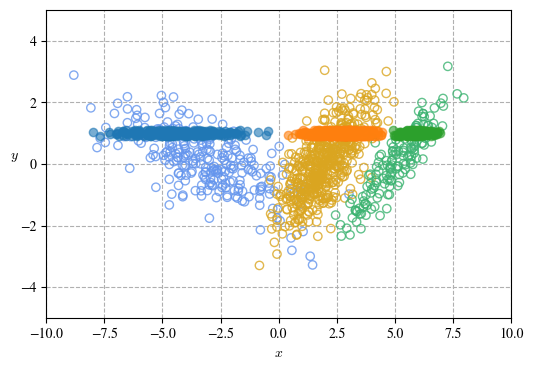

In [129]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

for c in np.unique(labels_pred):
    plt.scatter(x_test_neg[labels_pred==c], y_test_neg[labels_pred==c], zorder=2, alpha=0.6)

plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()